In [98]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [99]:
mydata= pd.read_csv("C:\\Users\\sheep\\OneDrive\\Documents\\GitHub\\WAMuseum\\numismatics_0.csv")
old_size = mydata.size

In [100]:
# Keep only the datapoints where there are images available
mydata = mydata[mydata['image_url'].notnull()]
print("Removed:", old_size - mydata.size)

Removed: 144864


In [101]:
before_size = mydata.shape[0]
mydata = mydata.drop_duplicates()
after_size = mydata.shape[0]
print("Duplicates removed:", before_size - after_size)

Duplicates removed: 0


In [102]:
# Remove the 'g' in the weights comulmn
mydata['Weight'] =  mydata['Weight'].str.extract('(\d+)').astype(float)

Playing around with cleaning / standardizing the data data

First we want to see, how many unknowns, full knowns and partially unknowns do we have

We follow a step by step process
1) Everything fully unknown goes into one catagory -> ?
2) Any time there is a full date but they are not sure, choose that date
3) If there is a range of dates 1620 - 1630, choose the middle: 1625
4) If the second number is missing 1??? we don't know enough so move to -> ?
5) Any time one or two numbers are missing: 162? or 17?? - Either remove or fill in 5 (thats in the middle)

In [180]:
mydata[['Date']] = mydata[['Date']].fillna('?')
mydata['Date'] =   mydata['Date'].str.replace(r"\(|\)", "", regex=True)

In [207]:
# Example: Converting a column to a specific data type
#mydata['Date'] = pd.to_datetime(mydata['Date'], errors = 'coerce')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(mydata['Date'].value_counts())

?                                        677
No Date                                  607
c.1650                                   452
No Date?1652                             415
No Date?1650                             402
c.1708                                   316
C. 1708                                  257
1620                                     255
c.1652                                   253
1622                                     234
1623                                     230
1653                                     208
1624                                     174
1621                                     168
1652                                     164
c. 1708                                  142
1619                                     112
no Date?1650                              99
c.1620                                    96
1654                                      86
1711                                      77
No Date?1651                              75
Not Known 

In [205]:
import regex as re
def count_consecutive_numbers(date):
    cntr = 0
    i = 0 # iterator
    date_list = [0,0,0]
    for c in date:
        i += 1
        if(c.isdigit()):
            cntr += 1
            if(cntr == 2):
                date_list[0] = int(date[i-cntr:i])
            if(cntr == 3):
                date_list[1] = int(date[i-cntr:i])
            if(cntr == 4):
                date_list[2] = int(date[i-cntr:i])
        else:
            cntr = 0
    
    number = np.argmax(date_list) # get the index of the max date
    return number + 2, date_list[number]

def replace_star_question(date):
    i = 0
    for c in date:
        if(c == '*' or c == '?'):
            if(i == 0):
                #print(date, ":", "1" + date[1:len(date)])
                return date.replace()
            elif(i == 2):
                return "15" + date[2:len(date)]
            elif(i == 3):
                return  date[0:1] + "5" + date[3:len(date)]
            elif(i == 4):
                return date[0:len(date)-1] + "0"
            i += 1


for date in mydata['Date'].unique():
    if(not date.isalpha()):
        full_date = 0
        # We count the numbers in the string:
        numbers = sum(c.isdigit() for c in date)

        # If there are exactly 4 (or more) consecutive numbers we have a date
        # With more then 4 we just choose the first... simple
        consec_numbers = count_consecutive_numbers(date)
        if(numbers >= 4 and consec_numbers[0] == 4):
            full_date = int(consec_numbers[1])

        # if there are exactly 3 consecutive numbers we can swap the missing number for a 5
        elif(numbers == 3 and consec_numbers[0] == 3):
            # If the first number is missing replace with an one if it's the last with a 5
            if(consec_numbers[1] < 200):
                full_date = int(str(consec_numbers[1]) + "5")
            else:
                full_date = int("1" + str(consec_numbers[1]))

        # if there are exactly 2 consecutive numbers we can swap the missing number for a 50        
        elif(numbers == 2 and consec_numbers[0] == 2):
            # If the first and last are missing add 1 and 0 to the beginning and end respectively
            if(consec_numbers[1] > 20):
                full_date = int("1" + str(consec_numbers[1]) + "0")
            else:
                full_date = int(str(consec_numbers[1]) + "50")

        # There are cases where there's a ? or *. Depending on the position we can replace it
        # 0: 1, 2/3: 5, 4: 0
        else:
            new_string = date.replace('?', '1').replace('*', '1').replace(' ', '').replace('-','')
            numbers = sum(c.isdigit() for c in new_string)
            consec_numbers = count_consecutive_numbers(new_string)
            if(numbers >= 4 and consec_numbers[0] == 4):
                full_date = int(consec_numbers[1])      
            

        if(full_date == 0):
            print(date + " :", numbers, " : ", consec_numbers[0], " : ", full_date)

? : 1  :  2  :  0
- : 0  :  2  :  0
N.D. : 0  :  2  :  0
N.V.D. : 0  :  2  :  0
61 uncertain9 : 3  :  2  :  0
161/20 : 5  :  3  :  0
6** : 3  :  3  :  0
161/26 : 5  :  3  :  0
161/22 : 5  :  3  :  0
Not Visible : 0  :  2  :  0
no Date : 0  :  2  :  0
No Date : 0  :  2  :  0
23.91 g : 4  :  2  :  0
No date : 0  :  2  :  0
not certain : 0  :  2  :  0
??3 : 3  :  3  :  0
?6? : 3  :  3  :  0
Not Known : 0  :  2  :  0
Not known : 0  :  2  :  0
not known : 0  :  2  :  0
not Known : 0  :  2  :  0
2 : 1  :  2  :  0
-4 : 1  :  2  :  0
4 : 1  :  2  :  0
8 : 1  :  2  :  0
- - -8 ? : 2  :  2  :  0
N0 Date : 1  :  2  :  0
?Date : 1  :  2  :  0
no date : 0  :  2  :  0
--1 : 1  :  2  :  0
No Date ? : 1  :  2  :  0


In [197]:
mydata['Date'].unique()

array(['1621', '16**', '1623', '1620 Uncertain', '1620', '156*', '?',
       '1622', 'c.1620', '1593', '1626', '1627', 'N.V.D. c.1623',
       'N.V.D. c.1620', '162* c.1620', '1624', '1625', '16** c. 1623',
       'NVD c. 1622', 'N.V.D. c. 1622', '15** 1554-58', '1578', '1606',
       '611', '15*0 c. 1590', 'N.V.D. c. 1620', '1612 or 1613', '1584',
       'unknown', '1598', '16** c.1620', 'NVD c.1620', '15** 1567-1571',
       '1568', 'c.1590', '1590', '15**', 'c.1568', '-', '1552',
       '1623 3 uncertain', '16** 1621-8', '1540', '605', '16** c.1623',
       'N.D.', 'N.V.D.', '1597', '1613', '1567', '1619', '15*2 1591-1593',
       '1602', '1592', '1611', '1628', '122', '1576-1612', 'N.D. 1620-27',
       'N.D. 1620-1627', '1591', '1587', '621', 'N.D. c.1570', '1572',
       '1624 Uncertain', 'N.V.D. c.1560-65', '162*', 'N.D. 1582', '1596',
       '159*', '1604', '1605', '1612', '1616', '16*4',
       'N.V.D. c. 1602-10', '162* 1624?', '623', 'N.D. c.1620', '1585',
       '606', '162

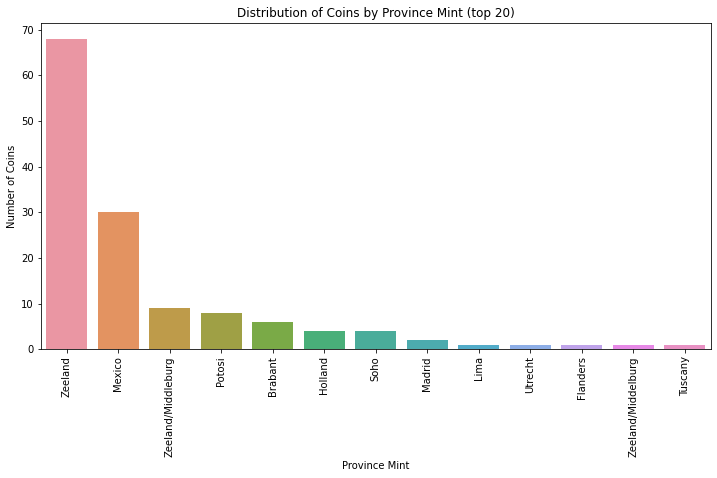

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each province mint
province_mint_counts = mydata['Province_Mint'].value_counts().head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=province_mint_counts.index, y=province_mint_counts.values)
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.xlabel('Province Mint')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins by Province Mint (top 20)')
plt.show()

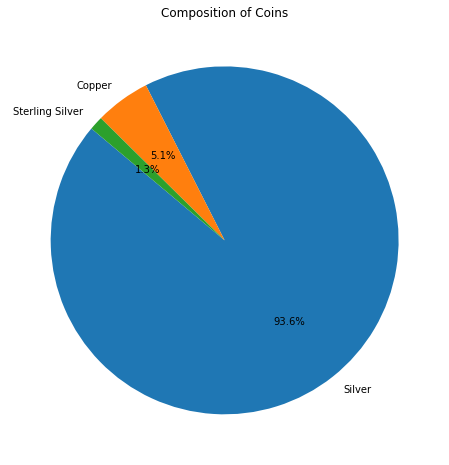

In [ ]:
# Composition distribution
composition_counts = mydata['Composition'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(composition_counts, labels=composition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Composition of Coins')
plt.show()

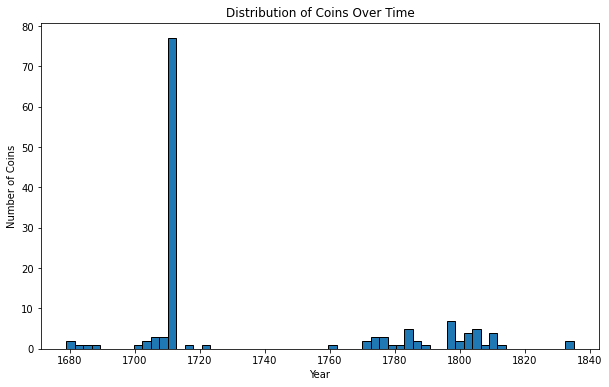

In [ ]:
# Assuming 'Date' column is in a proper numeric format
plt.figure(figsize=(10, 6))
plt.hist(mydata['Date'], bins=60, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins Over Time')
plt.show()

In [ ]:
# Assuming the 'Weight' column is already in a numeric format
# Calculate the IQR
Q1 = mydata['Weight'].quantile(0.25)
Q3 = mydata['Weight'].quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Remove outliers
mydata = mydata[(mydata['Weight'] >= lower_threshold) & (mydata['Weight'] <= upper_threshold)]

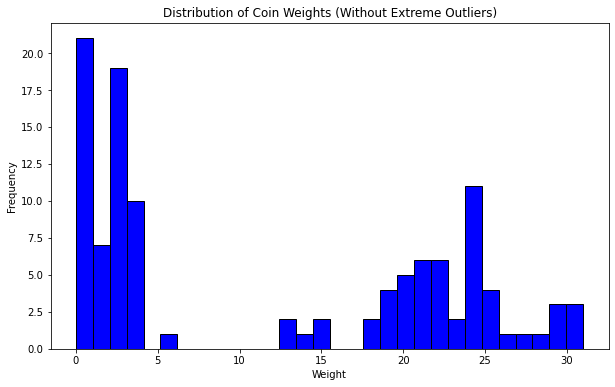

In [ ]:
# Plot histogram with a reasonable number of bins
plt.figure(figsize=(10, 6))
plt.hist(mydata['Weight'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Coin Weights (Without Extreme Outliers)')
plt.show()

In [ ]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 9664 to 16005
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   112 non-null    int64         
 1   Title                112 non-null    object        
 2   Type                 112 non-null    object        
 3   ANCODS               2 non-null      object        
 4   Catalogue            35 non-null     object        
 5   Composition          52 non-null     object        
 6   Condition            63 non-null     object        
 7   Date                 112 non-null    datetime64[ns]
 8   thumb_url            112 non-null    object        
 9   Mint_Mark            48 non-null     object        
 10  Other_Details        73 non-null     object        
 11  Province_Mint        111 non-null    object        
 12  Registration_Number  60 non-null     float64       
 13  Soverign_Issuer      112 non-n

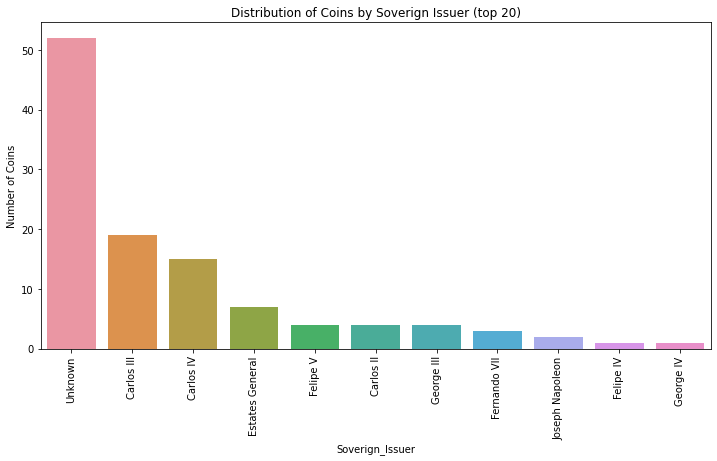

In [ ]:
# Count the occurrences of each province mint
soverign_issuer_counts = mydata['Soverign_Issuer'].value_counts().head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=soverign_issuer_counts.index, y=soverign_issuer_counts.values)
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.xlabel('Soverign_Issuer')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins by Soverign Issuer (top 20)')
plt.show()

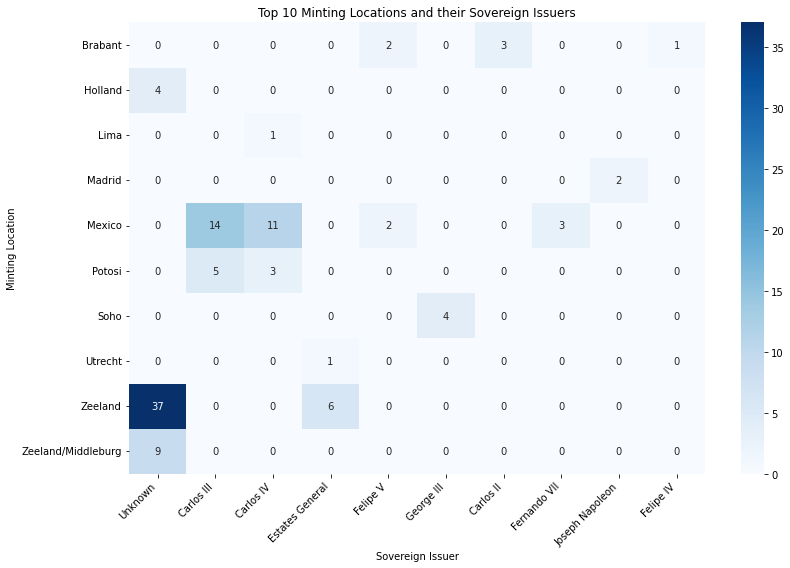

In [ ]:
# Find the top 10 minting locations based on frequency
top_mints = mydata['Province_Mint'].value_counts().head(10).index

# Filter the dataset to keep only the top 10 minting locations
mydata_top_mints = mydata[mydata['Province_Mint'].isin(top_mints)]

# Create a crosstab of the top 10 minting locations and their Sovereign Issuers
crosstab_data = pd.crosstab(mydata_top_mints['Province_Mint'], mydata_top_mints['Soverign_Issuer'])

# Sort the columns by the total counts to have the most frequent Sovereign Issuers appear first
crosstab_data = crosstab_data[crosstab_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_data, annot=True, fmt='d', cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Sovereign Issuer')
plt.ylabel('Minting Location')
plt.title('Top 10 Minting Locations and their Sovereign Issuers')
plt.tight_layout()  # Adjust layout to fit the plot and labels
plt.show()

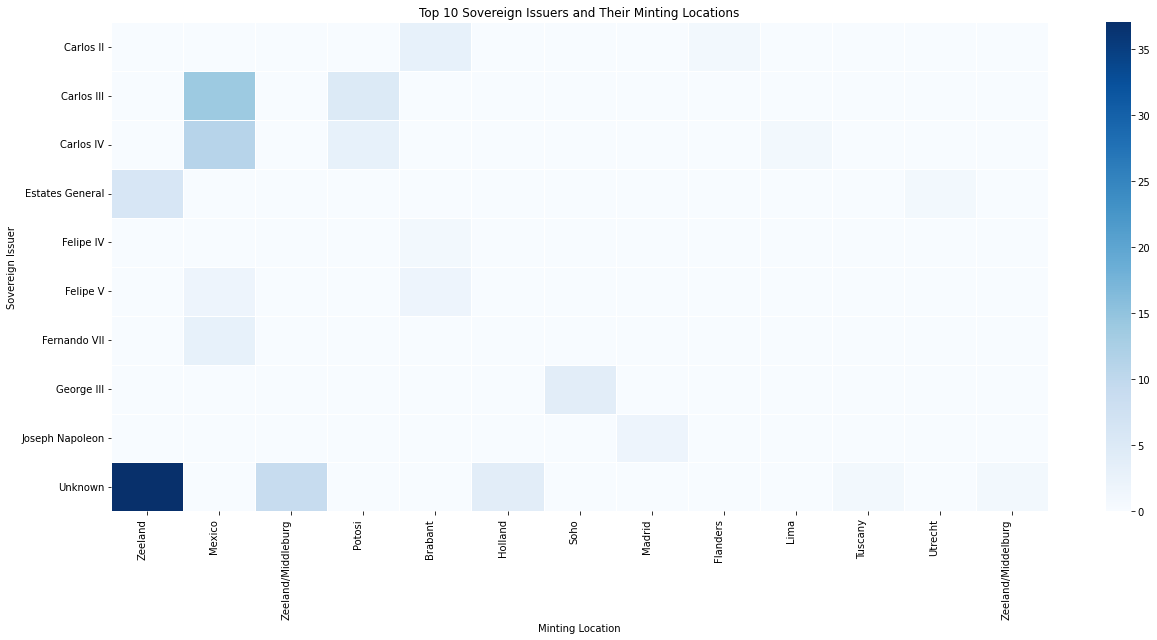

In [ ]:
# Find the top 10 Sovereign Issuers based on frequency
top_sovereigns = mydata['Soverign_Issuer'].value_counts().head(10).index

# Filter the dataset to keep only the top 10 Sovereign Issuers
mydata_top_sovereigns = mydata[mydata['Soverign_Issuer'].isin(top_sovereigns)]

# Create a crosstab of the top 10 Sovereign Issuers and their minting locations
crosstab_data = pd.crosstab(mydata_top_sovereigns['Soverign_Issuer'], mydata_top_sovereigns['Province_Mint'].sort_values(ascending=False))

# Sort the columns by the total counts to have the most frequent minting locations appear first
crosstab_data = crosstab_data.loc[:, crosstab_data.sum(axis=0).sort_values(ascending=False).index]

# Increase the size of the heatmap
plt.figure(figsize=(18, 9))

# Create the heatmap without annotations
sns.heatmap(crosstab_data, cmap='Blues', linewidths=.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)

# Set the labels and title
plt.ylabel('Sovereign Issuer')
plt.xlabel('Minting Location')
plt.title('Top 10 Sovereign Issuers and Their Minting Locations')

# Use tight_layout to adjust subplot params
plt.tight_layout()

# Show the plot
plt.show()

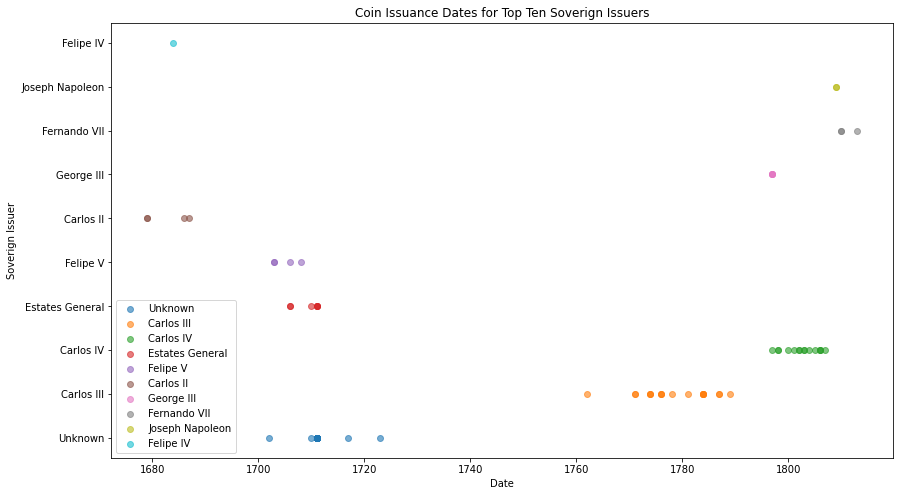

In [ ]:
# Identify the top ten sovereign issuers
top_issuers = mydata['Soverign_Issuer'].value_counts().head(10).index

# Filter the dataset for only the top ten issuers
top_issuers_data = mydata[mydata['Soverign_Issuer'].isin(top_issuers)]

# Create a scatter plot
plt.figure(figsize=(14, 8))
for issuer in top_issuers:
    # Select data for this issuer
    issuer_data = top_issuers_data[top_issuers_data['Soverign_Issuer'] == issuer]
    plt.scatter(issuer_data['Date'], issuer_data['Soverign_Issuer'], label=issuer, alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Soverign Issuer')
plt.title('Coin Issuance Dates for Top Ten Soverign Issuers')
plt.legend()
plt.show()